In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
pwd()

'/Users/prakharpatidar/Google Drive/DS/SML DS 5220/Project'

In [2]:
import sys
sys.path.append('./python_files')

In [4]:
#importing dependencies

#general
import random
import numpy as np
import os
import pandas as pd
import cv2
import pickle
import pprint
import ast
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_theme(style="dark")

#preprocessing
from data_preprocess import data_preprocess
from train_model import train_model
from sklearn.model_selection import train_test_split

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

#Neural nets
import tensorflow as tf
import torch
from torch import nn
import keras
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torchvision import utils
from torchvision.transforms import transforms
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Loading in the dataset

In [ ]:
image_classes = pd.read_csv('/content/drive/MyDrive/DS/SML DS 5220/Project/state-farm-distracted-driver-detection/driver_imgs_list.csv')

In [ ]:
image_classes.head()

In [ ]:
#Observing distribution of classes over dataset
image_classes['classname'].value_counts()

c0    2489
c3    2346
c4    2326
c6    2325
c2    2317
c5    2312
c1    2267
c9    2129
c7    2002
c8    1911
Name: classname, dtype: int64

In [ ]:
#loading class labels
with open('/content/drive/MyDrive/DS/SML DS 5220/Project/state-farm-distracted-driver-detection/class_labels.txt') as file:
  class_data = file.read()

class_labels = ast.literal_eval(class_data)
pprint.pprint(class_labels)


{'c0': 'Safe driving',
 'c1': 'Texting - right',
 'c2': 'Talking on the phone - right',
 'c3': 'Texting - left',
 'c4': 'Talking on the phone - left',
 'c5': 'Operating the radio',
 'c6': 'Drinking',
 'c7': 'Reaching behind',
 'c8': 'Hair and makeup',
 'c9': 'Talking to passenger'}


In [ ]:
image_classes['class'] = [class_labels[i] for i in image_classes['classname']]
image_classes.head()

,subject,classname,img,class
0,p002,c0,img_44733.jpg,Safe driving
1,p002,c0,img_72999.jpg,Safe driving
2,p002,c0,img_25094.jpg,Safe driving
3,p002,c0,img_69092.jpg,Safe driving
4,p002,c0,img_92629.jpg,Safe driving


In [ ]:
#loading in the data
features = pickle.load(open('/content/drive/MyDrive/DS/SML DS 5220/Project/state-farm-distracted-driver-detection/featureData.pkl','rb'))
target = pickle.load(open('/content/drive/MyDrive/DS/SML DS 5220/Project/state-farm-distracted-driver-detection/targetData.pkl','rb'))

print('Data Size: ', len(features))

Data Size:  22424


Shape of our images:  (128, 128, 3)


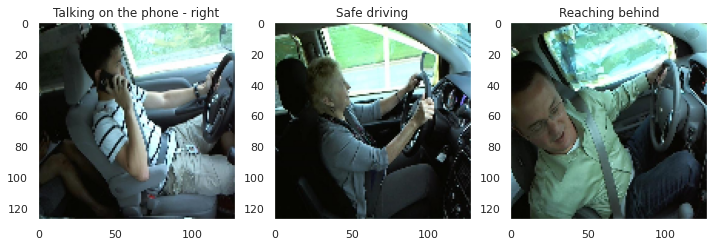

In [ ]:
#Visualizing 3 random images from the dataset and their classes
random.seed(15)
sample_idx = random.sample(range(1, len(features)),3)

print('Shape of our images: ',np.shape(features[sample_idx[0]]))

fig, ax = plt.subplots(1,3, figsize=(12,12))
i=0
for idx in sample_idx:
  im = features[idx]
  im_class = class_labels['c'+ str(target[idx])]
  ax[i].imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
  ax[i].set_title(im_class)
  i+= 1
plt.show()

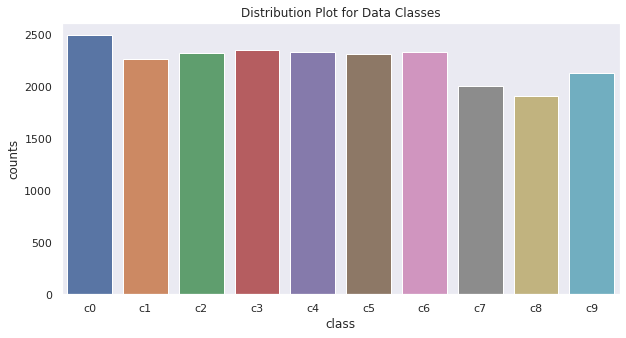

In [ ]:
# Calculating distributions of classes in the dataset
dist = np.asarray(np.unique(np.asarray(target), return_counts=True)).T
dist = pd.DataFrame(dist , columns = ['class','counts'])
dist['class'] = ['c'+str(i) for i in dist['class']]

plt.rcParams["figure.figsize"] = (10,5)
sns.barplot(x = dist['class'], y = dist['counts'])
plt.title('Distribution Plot for Data Classes')
plt.show()


#DL

In [5]:
#Importing data preprocessed to work with pytorch algorithms
preprocess_obj = data_preprocess('/content/drive/MyDrive/DS/SML DS 5220/Project/state-farm-distracted-driver-detection/imgs/train')

data = preprocess_obj.pytorch_dataloader()
len(data)

22424

In [6]:
#Importing data preprocessed to work with pytorch algorithms
preprocess_obj = data_preprocess('./state-farm-distracted-driver-detection/imgs/train')

data = preprocess_obj.pytorch_dataloader()
len(data)

22424

In [7]:
trainloader, testloader = preprocess_obj.split_data_train_test(data, test_split=0.33, batch_size= 64)
print(trainloader.dataset)
print('Classes: ',trainloader.dataset.classes)

Dataset ImageFolder
    Number of datapoints: 22424
    Root location: ./state-farm-distracted-driver-detection/imgs/train
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(224, 244), interpolation=PIL.Image.BILINEAR)
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Classes:  ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']


Pretrained VGG

In [8]:
import torch
torch.cuda.empty_cache()

In [9]:
from vgg16_transferlearning import VGG
num_samples = len(trainloader.dataset.classes)
vgg = VGG(num_samples).create_model()
vgg.to(device)
vgg.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=10, bias=True)
    (4): LogSoftmax(dim=1)
  )
)

In [10]:
#Initializing Negative log likelihood loss and Adam optimizer
criterion_vgg = nn.NLLLoss()
optimizer_vgg = optim.Adam(vgg.parameters(), lr=0.005)

In [ ]:
model_vgg, accuracy_vgg = train_model(
    model = vgg,
    trainset = trainloader, 
    testset = testloader,  
    criterion = criterion_vgg, 
    optimizer = optimizer_vgg, 
    num_epochs = 5, 
    device = device).batchRun()

Epoch:  0


CNN

In [ ]:
import torch
torch.cuda.empty_cache()

In [9]:
from cnn_5layer import CNN

In [10]:
cnn = CNN()
cnn.to(device)
cnn

CNN(
  (cnn_architecture): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, 

In [ ]:
criterion_cnn = nn.CrossEntropyLoss()
optimizer_cnn = torch.optim.Adam(cnn.parameters(), lr=0.01)

model_cnn, accuracy_cnn = train_model(
    model = cnn,
    trainset = trainloader, 
    testset = testloader,  
    criterion = criterion_cnn, 
    optimizer = optimizer_cnn, 
    num_epochs = 5, 
    device = device).batchRun()

Epoch:  0


KeyboardInterrupt: ignored